In [1]:
import sys
import numpy as np
from collections import defaultdict
import matlab.engine
import time
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
np.random.seed()

In [2]:
EPSILON = 0.0001
 
FAIRLETS = []
FAIRLET_CENTERS = []
 
class TreeNode:
 
    def __init__(self):
        self.children = []
 
    def set_cluster(self, cluster):
        self.cluster = cluster
 
    def add_child(self, child):
        self.children.append(child)
 
    def populate_colors(self, colors):
        "Populate auxiliary lists of red and blue points for each node, bottom-up"
        self.reds = []
        self.blues = []
        if len(self.children) == 0:
            # Leaf
            for i in self.cluster:
                if colors[i] == 0:
                    self.reds.append(i)
                else:
                    self.blues.append(i)
        else:
            # Not a leaf
            for child in self.children:
                child.populate_colors(colors)
                self.reds.extend(child.reds)
                self.blues.extend(child.blues)
 
 

In [3]:

### K-MEDIAN CODE ###
 
def kmedian_cost(points, centroids, dataset):
    "Computes and returns k-median cost for given dataset and centroids"
    return sum(np.amin(np.concatenate([np.linalg.norm(dataset[:,:]-dataset[centroid,:], axis=1).reshape((dataset.shape[0], 1)) for centroid in centroids], axis=1), axis=1))


In [4]:

def fair_kmedian_cost(centroids, dataset):
    "Return the fair k-median cost for given centroids and fairlet decomposition"
    total_cost = 0
    for i in range(len(FAIRLETS)):
        # Choose index of centroid which is closest to the i-th fairlet center
        cost_list = [np.linalg.norm(dataset[centroids[j],:]-dataset[FAIRLET_CENTERS[i],:]) for j in range(len(centroids))]
        cost, j = min((cost, j) for (j, cost) in enumerate(cost_list))
        # Assign all points in i-th fairlet to above centroid and compute cost
        total_cost += sum([np.linalg.norm(dataset[centroids[j],:]-dataset[point,:]) for point in FAIRLETS[i]])
    return total_cost
 

In [5]:

 
### FAIRLET DECOMPOSITION CODE ###
 
def balanced(p, q, r, b):
    if r==0 and b==0:
        return True
    if r==0 or b==0:
        return False
    return min(r*1./b, b*1./r) >= p*1./q
 
 

In [6]:

def make_fairlet(points, dataset):
    "Adds fairlet to fairlet decomposition, returns median cost"
    FAIRLETS.append(points)
   # print(dataset)
    cost_list = [sum([np.linalg.norm(dataset[center,:]-dataset[point,:]) for point in points]) for center in points]
    cost, center = min((cost, center) for (center, cost) in enumerate(cost_list))
    FAIRLET_CENTERS.append(points[center])
    return cost
 

In [7]:

 
def basic_fairlet_decomposition(p, q, blues, reds, dataset):
    """
    Computes vanilla (p,q)-fairlet decomposition of given points (Lemma 3 in NIPS17 paper).
    Returns cost.
    Input: Balance parameters p,q which are non-negative integers satisfying p<=q and gcd(p,q)=1.
    "blues" and "reds" are sets of points indices with balance at least p/q.
    """
    assert p <= q, "Please use balance parameters in the correct order"
    if len(reds) < len(blues):
        temp = blues
        blues = reds
        reds = temp
    R = len(reds)
    B = len(blues)
    assert balanced(p, q, R, B), "Input sets are unbalanced: "+str(R)+","+str(B)
 
    if R==0 and B==0:
        return 0
 
    b0 = 0
    r0 = 0
    cost = 0
    while (R-r0)-(B-b0) >= q-p and R-r0 >= q and B-b0 >= p:
        cost += make_fairlet(reds[r0:r0+q]+blues[b0:b0+p], dataset)
        r0 += q
        b0 += p
    if R-r0 + B-b0 >=1 and R-r0 + B-b0 <= p+q:
        cost += make_fairlet(reds[r0:]+blues[b0:], dataset)
        r0 = R
        b0 = B
    elif R-r0 != B-b0 and B-b0 >= p:
        cost += make_fairlet(reds[r0:r0+(R-r0)-(B-b0)+p]+blues[b0:b0+p], dataset)
        r0 += (R-r0)-(B-b0)+p
        b0 += p
    assert R-r0 == B-b0, "Error in computing fairlet decomposition"
    for i in range(R-r0):
        cost += make_fairlet([reds[r0+i], blues[b0+i]], dataset)
    return cost
 
 

In [8]:

def node_fairlet_decomposition(p, q, node, dataset, donelist, depth):

    # Leaf                                                                                          
    if len(node.children) == 0:
        node.reds = [i for i in node.reds if donelist[i]==0]
        node.blues = [i for i in node.blues if donelist[i]==0]
        assert balanced(p, q, len(node.reds), len(node.blues)), "Reached unbalanced leaf"
        return basic_fairlet_decomposition(p, q, node.blues, node.reds, dataset)
 
    # Preprocess children nodes to get rid of points that have already been clustered
    for child in node.children:
        child.reds = [i for i in child.reds if donelist[i]==0]
        child.blues = [i for i in child.blues if donelist[i]==0]
 
    R = [len(child.reds) for child in node.children]
    B = [len(child.blues) for child in node.children]
 
    if sum(R) == 0 or sum(B) == 0:
        assert sum(R)==0 and sum(B)==0, "One color class became empty for this node while the other did not"
        return 0
 
    NR = 0
    NB = 0
 
    # Phase 1: Add must-remove nodes
    for i in range(len(node.children)):
        if R[i] >= B[i]:
            must_remove_red = max(0, R[i] - int(np.floor(B[i]*q*1./p)))
            R[i] -= must_remove_red
            NR += must_remove_red
        else:
            must_remove_blue = max(0, B[i] - int(np.floor(R[i]*q*1./p)))
            B[i] -= must_remove_blue
            NB += must_remove_blue
 
    # Calculate how many points need to be added to smaller class until balance
    if NR >= NB:
        # Number of missing blues in (NR,NB)
        missing = max(0, int(np.ceil(NR*p*1./q)) - NB)
    else:
        # Number of missing reds in (NR,NB)
        missing = max(0, int(np.ceil(NB*p*1./q)) - NR)
         
    # Phase 2: Add may-remove nodes until (NR,NB) is balanced or until no more such nodes
    for i in range(len(node.children)):
        if missing == 0:
            assert balanced(p, q, NR, NB), "Something went wrong"
            break
        if NR >= NB:
            may_remove_blue = B[i] - int(np.ceil(R[i]*p*1./q))
            remove_blue = min(may_remove_blue, missing)
            B[i] -= remove_blue
            NB += remove_blue
            missing -= remove_blue
        else:
            may_remove_red = R[i] - int(np.ceil(B[i]*p*1./q))
            remove_red = min(may_remove_red, missing)
            R[i] -= remove_red
            NR += remove_red
            missing -= remove_red
 
    # Phase 3: Add unsatuated fairlets until (NR,NB) is balanced
    for i in range(len(node.children)):
        if balanced(p, q, NR, NB):
            break
        if R[i] >= B[i]:
            num_saturated_fairlets = int(R[i]/q)
            excess_red = R[i] - q*num_saturated_fairlets
            excess_blue = B[i] - p*num_saturated_fairlets
        else:
            num_saturated_fairlets = int(B[i]/q)
            excess_red = R[i] - p*num_saturated_fairlets
            excess_blue = B[i] - q*num_saturated_fairlets
        R[i] -= excess_red
        NR += excess_red
        B[i] -= excess_blue
        NB += excess_blue
 
    assert balanced(p, q, NR, NB), "Constructed node sets are unbalanced"
 
    reds = []
    blues = []
    for i in range(len(node.children)):
        for j in node.children[i].reds[R[i]:]:
            reds.append(j)
            donelist[j] = 1
        for j in node.children[i].blues[B[i]:]:
            blues.append(j)
            donelist[j] = 1
 
    assert len(reds)==NR and len(blues)==NB, "Something went horribly wrong"
 
    return basic_fairlet_decomposition(p, q, blues, reds, dataset) + sum([node_fairlet_decomposition(p, q, child, dataset, donelist, depth+1) for child in node.children])
 

In [9]:

 
def tree_fairlet_decomposition(p, q, root, dataset, colors):
    "Main fairlet clustering function, returns cost wrt original metric (not tree metric)"
    assert p <= q, "Please use balance parameters in the correct order"
    root.populate_colors(colors)
    assert balanced(p, q, len(root.reds), len(root.blues)), "Dataset is unbalanced"
    root.populate_colors(colors)
    donelist = [0] * dataset.shape[0]
    return node_fairlet_decomposition(p, q, root, dataset, donelist, 0)
 
 

In [10]:

### QUADTREE CODE ###
 
def build_quadtree(dataset, max_levels=0, random_shift=True):
    "If max_levels=0 there no level limit, quadtree will partition until all clusters are singletons"
    dimension = dataset.shape[1]
    lower = np.amin(dataset, axis=0)
    upper = np.amax(dataset, axis=0)
 
    shift = np.zeros(dimension)
    if random_shift:
        for d in range(dimension):
            spread = upper[d] - lower[d]
            shift[d] = np.random.uniform(0, spread)
            upper[d] += spread
 
    return build_quadtree_aux(dataset, range(dataset.shape[0]), lower, upper, max_levels, shift)
     
 

In [11]:

def build_quadtree_aux(dataset, cluster, lower, upper, max_levels, shift):
    """
    "lower" is the "bottom-left" (in all dimensions) corner of current hypercube
    "upper" is the "upper-right" (in all dimensions) corner of current hypercube
    """
 
    dimension = dataset.shape[1]
    cell_too_small = True
    for i in range(dimension):
        if upper[i]-lower[i] > EPSILON:
            cell_too_small = False
 
    node = TreeNode()
    if max_levels==1 or len(cluster)<=1 or cell_too_small:
        # Leaf
        node.set_cluster(cluster)
        return node
     
    # Non-leaf
    midpoint = 0.5 * (lower + upper)
    subclusters = defaultdict(list)
    for i in cluster:
        subclusters[tuple([dataset[i,d]+shift[d]<=midpoint[d] for d in range(dimension)])].append(i)
    for edge, subcluster in subclusters.items():
        sub_lower = np.zeros(dimension)
        sub_upper = np.zeros(dimension)
        for d in range(dimension):
            if edge[d]:
                sub_lower[d] = lower[d]
                sub_upper[d] = midpoint[d]
            else:
                sub_lower[d] = midpoint[d]
                sub_upper[d] = upper[d]
        node.add_child(build_quadtree_aux(dataset, subcluster, sub_lower, sub_upper, max_levels-1, shift))
    return node
 
 

**DIABETES DATASET PREPROCESSING** 

In [12]:

def load_diabetes(data_dir=''):

   # data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'
    _path = 'diabetic_data.csv'
    data_path = os.path.join(data_dir, _path)
  
    df = pd.read_csv(data_path, sep=',', header=[0])
    n = df.shape[0]
    #print(df.head())
    df = df.iloc[:,[3,4,9]]
    age_ = []
    gender_ =[]
    for index, row in df.iterrows():
        s = row['age']
        s = s[1:-1]
        a,b= s.split("-")
        age_.append((int(a)+int(b))//2);
        
        if row['gender']=='Female':
            gender_.append(1)
        else:
            gender_.append(0)
            
        
    df['age']=age_;
   # df['gender']=gender_;
    df=df.drop(4)
    #print(df.head())
    df=df.iloc[:,[1,2]]
        
    return  df.to_numpy(), np.array(gender_)

#load_diabetes()



**BANK DATASET PREPROCESSING** 

*Step 1: Data Preprocessing* 

In [13]:

def load_bank(data_dir=''):

    #data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'
    _path = 'bank.csv'
    data_path = os.path.join(data_dir, _path)
      
    df = pd.read_csv(data_path, sep=',', header=[0])
    df1 = df.loc[df['marital'] == 'married']
    df2 = df.loc[df['marital'] == 'single']
    df3 = df.loc[df['marital'] =='divorced']
    
    
    df = [df1, df2, df3]
    df = pd.concat(df)
    n = df.shape[0]
    
    sex = df['marital']
    sens_attributes = list(set(sex.astype(str).values))  
    sex_num = np.zeros(n, dtype=int)
    sex_num[sex.astype(str).values == 'married'] = 1  

    df = df.iloc[:, [0,5,11]]
    return  df.to_numpy(),sex_num
   
#load_bank()



**CENSUS DATASET PREPROCESSING** 

*Step 1: Data Preprocessing* 

In [14]:

def load_census(data_dir=''):

    #data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'
    _path = 'adult.data'
    data_path = os.path.join(data_dir, _path)

    df = pd.read_csv(data_path, sep=',', header=None)
    n = df.shape[0]
    
    df = df.iloc[:, [9,0,12,2,4,10]]
    
    sex = df[9]
    sens_attributes = list(set(sex.astype(str).values))  # =[' Female', ' Male']
    sex_num = np.zeros(n, dtype=int)
    sex_num[sex.astype(str).values == sens_attributes[1]] = 1  #female ko 1 set

   
   # df['gen']= sex_num
    df = df.iloc[:, [1,2,3,4,5]]
        
    
   
    return  df.to_numpy(),sex_num

#load_census()


**CENSUS II DATASET PREPROCESSING** 

*Step 1: Data Preprocessing* 

In [15]:
 
def load_censusII(data_dir=''):

   # data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'
    _path = 'USCensus1990raw.data.txt'
    data_path = os.path.join(data_dir, _path)

    df = pd.read_csv(data_path, sep='\t', header=None)
    n = df.shape[0]
    sex_num = df.iloc[:, 112].astype(int)

    selected_attributes = [12, 35, 36, 47, 53, 54, 55, 58, 60, 63, 64, 65, 73, 80, 81, 93, 94, 95, 96, 101, 109, 116,
                           118, 122, 124]

    
  
    df = df.iloc[:,selected_attributes]

    #df['type'] = sex_num
    
    #df = df.iloc[:,[25,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
    return df.to_numpy(), sex_num.to_numpy()

#load_censusII()

**Loading, fairlet decomposition & clusetering**


In [16]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

In [17]:
def load_dataset(dataset_name):
    if dataset_name=='diabetes':
        dataset,colors_ = load_diabetes()
    elif dataset_name=='census':
        dataset,colors_ = load_census()
    elif dataset_name=='censusII':
        dataset,colors_ = load_censusII()
    elif dataset_name=='bank':
        dataset,colors_ = load_bank()
    else:
        print('Using Randomised dataset')
        n_points = 1000
        dimension = 5
        dataset = np.random.random((n_points, dimension))
        colors_ = [np.random.randint(2) for i in range(n_points)]

    return dataset,colors_

In [18]:

def compute(p,q,k,dataset,colors_,sample_size,subSample):
    
    
    p = min(p,q)
    q = max(p,q)
    
    n_points = len(dataset)
    
    #print( p )
    #print(q)
    if  subSample==False:
        idx = np.arange(n_points)
        np.random.shuffle(idx)
        sample_size=n_points
        idx = idx[:sample_size]
        n_points = sample_size
        dataset = dataset[idx,:]
        colors = [colors_[i] for i in idx]
    else:
        iter =100
        temp = len(dataset)
        temp_dataset = dataset
        while iter>=0:
            n_points = temp
            dataset = temp_dataset
            idx = np.arange(n_points)
          #  print('Npoints is '+str(n_points))
           # print('Sample size is '+str(sample_size))
           # np.random.seed(quantumrandom.get_data())
            random.shuffle(idx)
            random.shuffle(idx)
            random.shuffle(idx)
            random.shuffle(idx)
            #print(random.random())
                      
            idx = idx[:sample_size]
           # print(idx)
            n_points = sample_size
            dataset = dataset[idx,:]
            colors = [colors_[i] for i in idx]
            a = len([ 1 for x in colors if x==1])
            b = len([ 1 for x in colors if x==0])
            #print('a '+str(a))
            #print('b '+str(b))
            c1 = a/b
            c2 = b/a
            t1 = truncate(c1,1)
            t2 = truncate(c2,1)
            t = min(t1,t2)
            tt = truncate(p/q,1)
            #print(t)
            #print(tt)
            if t == tt:
                break
            else: 
               # print('-------------------------------Sampling again : '+str(iter))
                #import time  as timr
                #timr.sleep(30) 
                iter = iter-1

    dimension = dataset[0].shape
    #print(dataset.shape)
    #print(len(colors))
    a = [ 1 for x in colors if x==1]
    b = [ 1 for x in colors if x==0]
  #  print("A "+str(len(a)))
   # print("B "+str(len(b)))
    
  #  print("Number of data points:", n_points)
   # print("Dimension:", dimension)
   # print("Balance:", p, q)

    #print("Constructing tree...")
    fairlet_s = time.time()
    root = build_quadtree(dataset)

    #print("Doing fair clustering...")
  #  print('Beofe = '+str(dataset.shape))
   # print(dataset)
    cost = tree_fairlet_decomposition(p, q, root, dataset, colors)
    fairlet_e = time.time()

    #print("Fairlet decomposition cost:", cost)
    fairlet_time = fairlet_e-fairlet_s;
    #print("Fairlet Decomposition Runtime: ", str(fairlet_time));
    #print("Doing k-median clustering on fairlet centers...")
    fairlet_center_idx = [dataset[index] for index in FAIRLET_CENTERS]
    fairlet_center_pt = np.array([np.array(xi) for xi in fairlet_center_idx])

    # convert points into matlab array format
    mat_matrix = matlab.double(fairlet_center_pt.tolist())

    # Run k-mediod code in Matlab
    cluster_s = time.time()
    eng = matlab.engine.start_matlab()
    # C: Cluster medoid locations, returned as
    # a numeric matrix.
    # C is a k-by-d matrix, where row j is the medoid of cluster j
    #
    # midx: Index to mat_matrix, returned as a column vector of indices.
    # midx is a k-by-1 vector and the indices satisfy C = X(midx,:)
    idx,C,sumd,D,midx,info = eng.kmedoids(mat_matrix,k,'Distance','euclidean', nargout=6)
    cluster_e = time.time()
    np_idx = (np.array(idx._data)).flatten()
    total_runtime = (fairlet_e-fairlet_s) + (cluster_e-cluster_s)
    
    #print("Total Runtime: ", str(total_runtime));

    # compute the indices of centers returned by Matlab in its input matrix
    # which is mat_matrix or fairlet_center_pt
    np_midx = (np.array(midx._data)).flatten()
    c_idx_matrix = np_midx.astype(int)
    #in matlab, arrays are numbered from 1
    c_idx_matrix[:] = [index - 1 for index in c_idx_matrix]

    # indices of center points in dataset
    centroids = [FAIRLET_CENTERS[index] for index in c_idx_matrix]

    #print("Computing fair k-median cost...")
    kmedian_cost = fair_kmedian_cost(centroids, dataset)
    #print("Fairlet decomposition cost:", cost)
    #print("k-Median cost:", kmedian_cost)
    
    return kmedian_cost,cost, fairlet_time, total_runtime

    

Collecting Analytics for different sample size 

In [19]:
kmed=[]
fcost=[]
fTime=[]
tTime=[]
iter_no =[]

p = 3
q = 5
k =20
step_size = 1000
dataset, colors_ = load_dataset('bank')


total_size = len(dataset)

for sample_size in range(1000,1001, step_size):
    #Subsample each sample size 10 times to find average for that value
    
    for i in range(0,1000):
        print('Iteration No : '+str(i))
       # print("***************---iteration: " +str(i)+"  -----******************")
        FAIRLETS.clear()
        FAIRLET_CENTERS.clear()
        kmedian_cost,cost, fairlet_time, total_runtime = compute(p,q,k,dataset,colors_,sample_size,True)
        kmed.append(kmedian_cost)
        fcost.append(cost)
        fTime.append(fairlet_time)
        tTime.append(total_runtime)
        iter_no.append(i)
        print('Fairlet Decomposition Cost '+str((cost)))
        print('K-median Cost '+str((kmedian_cost)))
        print('Fairlet Decomposition RunTime '+str((fairlet_time)))
        print('Total RunTime '+str((total_runtime)))
        print("*************************************************************\n")

    kmed=np.array(kmed)
    fcost = np.array(fcost)
    fTime=np.array(fTime)
    tTime=np.array(tTime)
    iter_no = np.array(iter_no)
    print("Overall Results for 1000 Iteration: \n")
    print('Fairlet Decomposition Cost '+str(np.average(fcost)))
    print('K-median Cost '+str(np.average(kmed)))
    print('Fairlet Decomposition RunTime '+str(np.average(fTime)))
    print('Total RunTime '+str(np.average(tTime)))
    print("*************************************************************\n")



Iteration No : 0
Fairlet Decomposition Cost 1131250.0624979327
K-median Cost 1155149.2267170402
Fairlet Decomposition RunTime 0.13243746757507324
Total RunTime 7.863828420639038
*************************************************************

Iteration No : 1
Fairlet Decomposition Cost 857218.9337089814
K-median Cost 885835.2493676936
Fairlet Decomposition RunTime 0.1902318000793457
Total RunTime 9.415135383605957
*************************************************************

Iteration No : 2
Fairlet Decomposition Cost 913051.6243531948
K-median Cost 942748.8899102226
Fairlet Decomposition RunTime 0.11738443374633789
Total RunTime 8.156837463378906
*************************************************************

Iteration No : 3
Fairlet Decomposition Cost 898029.3439490502
K-median Cost 915966.8187004724
Fairlet Decomposition RunTime 0.1330578327178955
Total RunTime 7.343945741653442
*************************************************************

Iteration No : 4
Fairlet Decomposition Cost 

Fairlet Decomposition Cost 799932.1665904109
K-median Cost 827538.2120239576
Fairlet Decomposition RunTime 0.17596697807312012
Total RunTime 7.451890707015991
*************************************************************

Iteration No : 36
Fairlet Decomposition Cost 980075.5802876218
K-median Cost 1007190.4349720259
Fairlet Decomposition RunTime 0.16158413887023926
Total RunTime 8.193805694580078
*************************************************************

Iteration No : 37
Fairlet Decomposition Cost 1075560.7486268603
K-median Cost 1097143.8144698034
Fairlet Decomposition RunTime 0.15744423866271973
Total RunTime 7.800718545913696
*************************************************************

Iteration No : 38
Fairlet Decomposition Cost 698783.7576789616
K-median Cost 726768.7700970116
Fairlet Decomposition RunTime 0.2314755916595459
Total RunTime 8.222022294998169
*************************************************************

Iteration No : 39
Fairlet Decomposition Cost 947957.7681

Fairlet Decomposition Cost 913953.449145848
K-median Cost 943349.629367933
Fairlet Decomposition RunTime 0.15574312210083008
Total RunTime 11.747634887695312
*************************************************************

Iteration No : 71
Fairlet Decomposition Cost 866401.9710880795
K-median Cost 894025.8160444068
Fairlet Decomposition RunTime 0.20807576179504395
Total RunTime 8.567124843597412
*************************************************************

Iteration No : 72
Fairlet Decomposition Cost 721225.4796572084
K-median Cost 745693.8444380907
Fairlet Decomposition RunTime 0.1647334098815918
Total RunTime 9.792072534561157
*************************************************************

Iteration No : 73
Fairlet Decomposition Cost 802498.3274791556
K-median Cost 833507.1743321752
Fairlet Decomposition RunTime 0.2724597454071045
Total RunTime 7.929203987121582
*************************************************************

Iteration No : 74
Fairlet Decomposition Cost 872612.811082732

Fairlet Decomposition Cost 768148.3889171687
K-median Cost 801003.4814449128
Fairlet Decomposition RunTime 0.15387940406799316
Total RunTime 8.538711547851562
*************************************************************

Iteration No : 106
Fairlet Decomposition Cost 910382.7010168656
K-median Cost 930890.9118373913
Fairlet Decomposition RunTime 0.12299966812133789
Total RunTime 14.86193037033081
*************************************************************

Iteration No : 107
Fairlet Decomposition Cost 651490.6175702232
K-median Cost 683444.2388665169
Fairlet Decomposition RunTime 0.24150753021240234
Total RunTime 11.953500747680664
*************************************************************

Iteration No : 108
Fairlet Decomposition Cost 567431.1596894572
K-median Cost 590984.9161956245
Fairlet Decomposition RunTime 0.14020919799804688
Total RunTime 10.228343486785889
*************************************************************

Iteration No : 109
Fairlet Decomposition Cost 738075.

Fairlet Decomposition Cost 964203.3200911894
K-median Cost 984581.9800929299
Fairlet Decomposition RunTime 0.15980195999145508
Total RunTime 41.16666555404663
*************************************************************

Iteration No : 140
Fairlet Decomposition Cost 925762.0250696847
K-median Cost 950200.4594502902
Fairlet Decomposition RunTime 0.1984574794769287
Total RunTime 34.2179913520813
*************************************************************

Iteration No : 141
Fairlet Decomposition Cost 1075055.8393001761
K-median Cost 1099726.4811478653
Fairlet Decomposition RunTime 0.12610316276550293
Total RunTime 34.600114822387695
*************************************************************

Iteration No : 142
Fairlet Decomposition Cost 955530.7123715808
K-median Cost 971470.4112401699
Fairlet Decomposition RunTime 0.11970043182373047
Total RunTime 33.91544222831726
*************************************************************

Iteration No : 143
Fairlet Decomposition Cost 708051.9

Fairlet Decomposition Cost 893230.3612080549
K-median Cost 913962.9611462178
Fairlet Decomposition RunTime 0.11828041076660156
Total RunTime 34.86845779418945
*************************************************************

Iteration No : 174
Fairlet Decomposition Cost 781837.8775455852
K-median Cost 807192.2088613808
Fairlet Decomposition RunTime 0.12872076034545898
Total RunTime 33.346903800964355
*************************************************************

Iteration No : 175
Fairlet Decomposition Cost 786370.008337382
K-median Cost 817424.0363892632
Fairlet Decomposition RunTime 0.17186903953552246
Total RunTime 31.1567440032959
*************************************************************

Iteration No : 176
Fairlet Decomposition Cost 999746.0553722741
K-median Cost 1022962.0188174703
Fairlet Decomposition RunTime 0.12773847579956055
Total RunTime 34.873321533203125
*************************************************************

Iteration No : 177
Fairlet Decomposition Cost 777045.9

Fairlet Decomposition Cost 638940.5506872042
K-median Cost 665097.3989105491
Fairlet Decomposition RunTime 0.18915247917175293
Total RunTime 33.60983657836914
*************************************************************

Iteration No : 208
Fairlet Decomposition Cost 679429.1407254477
K-median Cost 704937.1457010014
Fairlet Decomposition RunTime 0.1430187225341797
Total RunTime 33.931015491485596
*************************************************************

Iteration No : 209
Fairlet Decomposition Cost 709890.2776697534
K-median Cost 737269.5100476046
Fairlet Decomposition RunTime 0.15549945831298828
Total RunTime 33.87009930610657
*************************************************************

Iteration No : 210
Fairlet Decomposition Cost 803589.2959332194
K-median Cost 827424.7097313008
Fairlet Decomposition RunTime 0.4351789951324463
Total RunTime 33.83429169654846
*************************************************************

Iteration No : 211
Fairlet Decomposition Cost 767338.103

Fairlet Decomposition Cost 1126353.5582229386
K-median Cost 1143819.9275222532
Fairlet Decomposition RunTime 0.12554264068603516
Total RunTime 8.895729303359985
*************************************************************

Iteration No : 243
Fairlet Decomposition Cost 925190.17868471
K-median Cost 950133.1837385191
Fairlet Decomposition RunTime 0.14666080474853516
Total RunTime 7.90895938873291
*************************************************************

Iteration No : 244
Fairlet Decomposition Cost 961274.8086891242
K-median Cost 986460.1942529667
Fairlet Decomposition RunTime 0.20548057556152344
Total RunTime 8.406594276428223
*************************************************************

Iteration No : 245
Fairlet Decomposition Cost 753038.6192233558
K-median Cost 778563.3201399789
Fairlet Decomposition RunTime 0.14728641510009766
Total RunTime 9.458740711212158
*************************************************************

Iteration No : 246
Fairlet Decomposition Cost 977830.004

Fairlet Decomposition Cost 814525.9427791056
K-median Cost 836791.5034682361
Fairlet Decomposition RunTime 0.1607646942138672
Total RunTime 8.3657865524292
*************************************************************

Iteration No : 278
Fairlet Decomposition Cost 903962.466108685
K-median Cost 936171.1228976768
Fairlet Decomposition RunTime 0.13879752159118652
Total RunTime 7.261090993881226
*************************************************************

Iteration No : 279
Fairlet Decomposition Cost 1119526.7126409654
K-median Cost 1142379.4344793272
Fairlet Decomposition RunTime 0.1538558006286621
Total RunTime 8.788061380386353
*************************************************************

Iteration No : 280
Fairlet Decomposition Cost 827752.7516214093
K-median Cost 857474.6302106295
Fairlet Decomposition RunTime 0.17359232902526855
Total RunTime 8.082733154296875
*************************************************************

Iteration No : 281
Fairlet Decomposition Cost 1249625.6313

Fairlet Decomposition Cost 1014909.3466166002
K-median Cost 1041496.3907198113
Fairlet Decomposition RunTime 0.12244796752929688
Total RunTime 9.584261655807495
*************************************************************

Iteration No : 312
Fairlet Decomposition Cost 1042845.692653574
K-median Cost 1061662.1222971957
Fairlet Decomposition RunTime 0.1728346347808838
Total RunTime 8.971210956573486
*************************************************************

Iteration No : 313
Fairlet Decomposition Cost 874658.0496191336
K-median Cost 911806.6326992979
Fairlet Decomposition RunTime 0.2948179244995117
Total RunTime 7.775877475738525
*************************************************************

Iteration No : 314
Fairlet Decomposition Cost 759313.5357954632
K-median Cost 783722.5797202447
Fairlet Decomposition RunTime 0.25652480125427246
Total RunTime 8.800889253616333
*************************************************************

Iteration No : 315
Fairlet Decomposition Cost 808289.2

Fairlet Decomposition Cost 782957.800799099
K-median Cost 810559.5981914869
Fairlet Decomposition RunTime 0.1699354648590088
Total RunTime 8.25686764717102
*************************************************************

Iteration No : 347
Fairlet Decomposition Cost 1017172.6909363937
K-median Cost 1044974.3638282442
Fairlet Decomposition RunTime 0.22794508934020996
Total RunTime 7.811169862747192
*************************************************************

Iteration No : 348
Fairlet Decomposition Cost 1068423.1849413614
K-median Cost 1084728.0716782422
Fairlet Decomposition RunTime 0.22348642349243164
Total RunTime 8.104544401168823
*************************************************************

Iteration No : 349
Fairlet Decomposition Cost 975697.3274565042
K-median Cost 1009291.7796577815
Fairlet Decomposition RunTime 0.19957900047302246
Total RunTime 7.390396595001221
*************************************************************

Iteration No : 350
Fairlet Decomposition Cost 818170.

Fairlet Decomposition Cost 639707.5371103522
K-median Cost 670545.0580534318
Fairlet Decomposition RunTime 0.13026881217956543
Total RunTime 7.637219429016113
*************************************************************

Iteration No : 382
Fairlet Decomposition Cost 813256.1319637297
K-median Cost 844067.0571282159
Fairlet Decomposition RunTime 0.23354506492614746
Total RunTime 8.306661605834961
*************************************************************

Iteration No : 383
Fairlet Decomposition Cost 896811.9837456997
K-median Cost 921218.3115071937
Fairlet Decomposition RunTime 0.11128067970275879
Total RunTime 7.533008098602295
*************************************************************

Iteration No : 384
Fairlet Decomposition Cost 698349.4636665524
K-median Cost 728457.7862178311
Fairlet Decomposition RunTime 0.20566415786743164
Total RunTime 8.414522171020508
*************************************************************

Iteration No : 385
Fairlet Decomposition Cost 929781.57

Fairlet Decomposition Cost 648226.246033921
K-median Cost 675258.4575490077
Fairlet Decomposition RunTime 0.2489774227142334
Total RunTime 7.9525957107543945
*************************************************************

Iteration No : 417
Fairlet Decomposition Cost 886816.0929534398
K-median Cost 917095.1978285597
Fairlet Decomposition RunTime 0.2653825283050537
Total RunTime 9.112613677978516
*************************************************************

Iteration No : 418
Fairlet Decomposition Cost 622092.5907671261
K-median Cost 650700.2200736544
Fairlet Decomposition RunTime 0.21606707572937012
Total RunTime 8.7602379322052
*************************************************************

Iteration No : 419
Fairlet Decomposition Cost 919466.7487579536
K-median Cost 944295.9599112055
Fairlet Decomposition RunTime 0.15163636207580566
Total RunTime 9.097334146499634
*************************************************************

Iteration No : 420
Fairlet Decomposition Cost 1067194.81327

Fairlet Decomposition Cost 729057.6937306207
K-median Cost 760455.9803627906
Fairlet Decomposition RunTime 0.1368858814239502
Total RunTime 7.079482555389404
*************************************************************

Iteration No : 452
Fairlet Decomposition Cost 1168758.9564400823
K-median Cost 1188778.0587389409
Fairlet Decomposition RunTime 0.15384221076965332
Total RunTime 8.962153911590576
*************************************************************

Iteration No : 453
Fairlet Decomposition Cost 971978.9388993538
K-median Cost 995441.2723946739
Fairlet Decomposition RunTime 0.16928958892822266
Total RunTime 14.19915771484375
*************************************************************

Iteration No : 454
Fairlet Decomposition Cost 765747.5622830633
K-median Cost 792617.6777630594
Fairlet Decomposition RunTime 0.13261151313781738
Total RunTime 9.794046878814697
*************************************************************

Iteration No : 455
Fairlet Decomposition Cost 986199.8

Fairlet Decomposition Cost 896197.3275963552
K-median Cost 918592.8030224654
Fairlet Decomposition RunTime 0.32483911514282227
Total RunTime 9.4285147190094
*************************************************************

Iteration No : 487
Fairlet Decomposition Cost 707621.50658514
K-median Cost 741574.7973039871
Fairlet Decomposition RunTime 0.1852567195892334
Total RunTime 8.810251235961914
*************************************************************

Iteration No : 488
Fairlet Decomposition Cost 729412.4065898245
K-median Cost 766486.1880951643
Fairlet Decomposition RunTime 0.2556788921356201
Total RunTime 9.356160163879395
*************************************************************

Iteration No : 489
Fairlet Decomposition Cost 779476.5479921045
K-median Cost 806820.7538175598
Fairlet Decomposition RunTime 0.24089860916137695
Total RunTime 8.236875772476196
*************************************************************

Iteration No : 490
Fairlet Decomposition Cost 652032.68518061

Fairlet Decomposition Cost 749910.5757879221
K-median Cost 775678.8216718958
Fairlet Decomposition RunTime 0.1280972957611084
Total RunTime 10.581325054168701
*************************************************************

Iteration No : 522
Fairlet Decomposition Cost 668852.3614674195
K-median Cost 692788.9277009806
Fairlet Decomposition RunTime 0.20972490310668945
Total RunTime 12.64100456237793
*************************************************************

Iteration No : 523
Fairlet Decomposition Cost 851895.9422698515
K-median Cost 880944.5314742856
Fairlet Decomposition RunTime 0.26760005950927734
Total RunTime 11.777629852294922
*************************************************************

Iteration No : 524
Fairlet Decomposition Cost 786529.3123668275
K-median Cost 816476.5492686034
Fairlet Decomposition RunTime 0.11003947257995605
Total RunTime 7.7565155029296875
*************************************************************

Iteration No : 525
Fairlet Decomposition Cost 1041990

Fairlet Decomposition Cost 873568.0276277865
K-median Cost 904799.6412431262
Fairlet Decomposition RunTime 0.18882989883422852
Total RunTime 8.994070768356323
*************************************************************

Iteration No : 557
Fairlet Decomposition Cost 856297.7177653882
K-median Cost 882990.5747330409
Fairlet Decomposition RunTime 0.19500279426574707
Total RunTime 8.093524694442749
*************************************************************

Iteration No : 558
Fairlet Decomposition Cost 843614.2885582359
K-median Cost 873642.6265576384
Fairlet Decomposition RunTime 0.2825446128845215
Total RunTime 9.941343545913696
*************************************************************

Iteration No : 559
Fairlet Decomposition Cost 684514.8366399307
K-median Cost 715164.4292655368
Fairlet Decomposition RunTime 0.11800265312194824
Total RunTime 8.323293685913086
*************************************************************

Iteration No : 560
Fairlet Decomposition Cost 606795.488

Fairlet Decomposition Cost 938384.4689675901
K-median Cost 967151.4042249703
Fairlet Decomposition RunTime 0.1176600456237793
Total RunTime 8.364495754241943
*************************************************************

Iteration No : 592
Fairlet Decomposition Cost 994122.4970966931
K-median Cost 1018143.1534602462
Fairlet Decomposition RunTime 0.2581930160522461
Total RunTime 9.459691047668457
*************************************************************

Iteration No : 593
Fairlet Decomposition Cost 801248.5594155183
K-median Cost 838287.2602591264
Fairlet Decomposition RunTime 0.16214585304260254
Total RunTime 8.996134042739868
*************************************************************

Iteration No : 594
Fairlet Decomposition Cost 672913.293493045
K-median Cost 700040.784563966
Fairlet Decomposition RunTime 0.31895923614501953
Total RunTime 7.705592155456543
*************************************************************

Iteration No : 595
Fairlet Decomposition Cost 740878.90219

Fairlet Decomposition Cost 956675.1707584403
K-median Cost 979057.9758028942
Fairlet Decomposition RunTime 0.22699356079101562
Total RunTime 8.257027864456177
*************************************************************

Iteration No : 627
Fairlet Decomposition Cost 720699.3927838905
K-median Cost 756369.8088813269
Fairlet Decomposition RunTime 0.353961706161499
Total RunTime 7.685562610626221
*************************************************************

Iteration No : 628
Fairlet Decomposition Cost 1054913.9029583232
K-median Cost 1078857.3859681657
Fairlet Decomposition RunTime 0.12174582481384277
Total RunTime 8.132011890411377
*************************************************************

Iteration No : 629
Fairlet Decomposition Cost 1116178.0816941592
K-median Cost 1137108.6827804504
Fairlet Decomposition RunTime 0.16792941093444824
Total RunTime 10.259404420852661
*************************************************************

Iteration No : 630
Fairlet Decomposition Cost 718496

Fairlet Decomposition Cost 1078692.2067768131
K-median Cost 1106123.4607045157
Fairlet Decomposition RunTime 0.21793031692504883
Total RunTime 9.53859543800354
*************************************************************

Iteration No : 661
Fairlet Decomposition Cost 654620.0168970801
K-median Cost 681908.4540608142
Fairlet Decomposition RunTime 0.22614574432373047
Total RunTime 10.89537525177002
*************************************************************

Iteration No : 662
Fairlet Decomposition Cost 697918.4885320304
K-median Cost 727511.5120388712
Fairlet Decomposition RunTime 0.20404577255249023
Total RunTime 13.878281354904175
*************************************************************

Iteration No : 663
Fairlet Decomposition Cost 939895.2741064688
K-median Cost 962802.9365590439
Fairlet Decomposition RunTime 0.22715210914611816
Total RunTime 9.384490966796875
*************************************************************

Iteration No : 664
Fairlet Decomposition Cost 697393.

Fairlet Decomposition Cost 1071575.3087912428
K-median Cost 1098759.8559796107
Fairlet Decomposition RunTime 0.16948461532592773
Total RunTime 8.286620140075684
*************************************************************

Iteration No : 696
Fairlet Decomposition Cost 787368.7175660894
K-median Cost 810840.3627368052
Fairlet Decomposition RunTime 0.1638181209564209
Total RunTime 8.657686471939087
*************************************************************

Iteration No : 697
Fairlet Decomposition Cost 814820.503072987
K-median Cost 833842.7972177768
Fairlet Decomposition RunTime 0.27397775650024414
Total RunTime 9.137819051742554
*************************************************************

Iteration No : 698
Fairlet Decomposition Cost 943712.568250835
K-median Cost 965055.958548791
Fairlet Decomposition RunTime 0.15767240524291992
Total RunTime 9.009627342224121
*************************************************************

Iteration No : 699
Fairlet Decomposition Cost 773259.3388

Fairlet Decomposition Cost 998122.3753273573
K-median Cost 1020077.2150250365
Fairlet Decomposition RunTime 0.16663694381713867
Total RunTime 9.409180164337158
*************************************************************

Iteration No : 731
Fairlet Decomposition Cost 762979.8477894387
K-median Cost 793528.8774228061
Fairlet Decomposition RunTime 0.20284748077392578
Total RunTime 8.866886615753174
*************************************************************

Iteration No : 732
Fairlet Decomposition Cost 679598.1927760798
K-median Cost 712815.7203437204
Fairlet Decomposition RunTime 0.11206698417663574
Total RunTime 7.885134220123291
*************************************************************

Iteration No : 733
Fairlet Decomposition Cost 600746.015023665
K-median Cost 635305.3649218498
Fairlet Decomposition RunTime 0.15741276741027832
Total RunTime 9.491047382354736
*************************************************************

Iteration No : 734
Fairlet Decomposition Cost 738950.28

Fairlet Decomposition Cost 782761.4666606444
K-median Cost 807587.3924629504
Fairlet Decomposition RunTime 0.24865007400512695
Total RunTime 8.42038345336914
*************************************************************

Iteration No : 766
Fairlet Decomposition Cost 909248.1113262762
K-median Cost 927994.6050497043
Fairlet Decomposition RunTime 0.1583867073059082
Total RunTime 8.518479347229004
*************************************************************

Iteration No : 767
Fairlet Decomposition Cost 985504.3910404915
K-median Cost 1008171.1520733058
Fairlet Decomposition RunTime 0.28592777252197266
Total RunTime 8.08739972114563
*************************************************************

Iteration No : 768
Fairlet Decomposition Cost 1227156.171180458
K-median Cost 1246596.0787715511
Fairlet Decomposition RunTime 0.11559057235717773
Total RunTime 9.437603235244751
*************************************************************

Iteration No : 769
Fairlet Decomposition Cost 921876.301

Fairlet Decomposition Cost 874035.977578328
K-median Cost 903513.266550009
Fairlet Decomposition RunTime 0.17261457443237305
Total RunTime 9.175360202789307
*************************************************************

Iteration No : 801
Fairlet Decomposition Cost 817279.330013675
K-median Cost 839721.3262719687
Fairlet Decomposition RunTime 0.14640021324157715
Total RunTime 9.480144262313843
*************************************************************

Iteration No : 802
Fairlet Decomposition Cost 767812.2424498618
K-median Cost 796750.6334935566
Fairlet Decomposition RunTime 0.24744343757629395
Total RunTime 8.968473672866821
*************************************************************

Iteration No : 803
Fairlet Decomposition Cost 623892.4713243872
K-median Cost 657798.1215092477
Fairlet Decomposition RunTime 0.15580201148986816
Total RunTime 8.384830713272095
*************************************************************

Iteration No : 804
Fairlet Decomposition Cost 1252986.3099

Fairlet Decomposition Cost 1234711.2593209406
K-median Cost 1258544.4853685433
Fairlet Decomposition RunTime 0.3809549808502197
Total RunTime 13.101251363754272
*************************************************************

Iteration No : 836
Fairlet Decomposition Cost 770103.2360648187
K-median Cost 789356.3811981425
Fairlet Decomposition RunTime 0.27059268951416016
Total RunTime 12.512581586837769
*************************************************************

Iteration No : 837
Fairlet Decomposition Cost 848149.7074399805
K-median Cost 877310.9420632293
Fairlet Decomposition RunTime 0.35998964309692383
Total RunTime 8.22095799446106
*************************************************************

Iteration No : 838
Fairlet Decomposition Cost 686509.7298018439
K-median Cost 712656.5014017911
Fairlet Decomposition RunTime 0.172957181930542
Total RunTime 8.509371042251587
*************************************************************

Iteration No : 839
Fairlet Decomposition Cost 961247.33

Fairlet Decomposition Cost 768622.6986804897
K-median Cost 792451.736948489
Fairlet Decomposition RunTime 0.20586919784545898
Total RunTime 8.757498502731323
*************************************************************

Iteration No : 871
Fairlet Decomposition Cost 845048.6302365168
K-median Cost 872502.6158463538
Fairlet Decomposition RunTime 0.1920180320739746
Total RunTime 7.794149160385132
*************************************************************

Iteration No : 872
Fairlet Decomposition Cost 753167.4211566125
K-median Cost 780624.5547546616
Fairlet Decomposition RunTime 0.26070094108581543
Total RunTime 7.935221433639526
*************************************************************

Iteration No : 873
Fairlet Decomposition Cost 816726.9014829178
K-median Cost 850062.4657351403
Fairlet Decomposition RunTime 0.15099525451660156
Total RunTime 8.7577223777771
*************************************************************

Iteration No : 874
Fairlet Decomposition Cost 964427.961827

Fairlet Decomposition Cost 722773.2224159057
K-median Cost 754733.508383454
Fairlet Decomposition RunTime 0.15968608856201172
Total RunTime 9.060155153274536
*************************************************************

Iteration No : 906
Fairlet Decomposition Cost 706361.6379309673
K-median Cost 732661.4125916611
Fairlet Decomposition RunTime 0.14688396453857422
Total RunTime 8.25058627128601
*************************************************************

Iteration No : 907
Fairlet Decomposition Cost 856811.8416185667
K-median Cost 879931.7680796162
Fairlet Decomposition RunTime 0.23150134086608887
Total RunTime 7.791973114013672
*************************************************************

Iteration No : 908
Fairlet Decomposition Cost 791921.6681937996
K-median Cost 822748.2045472465
Fairlet Decomposition RunTime 0.259368896484375
Total RunTime 9.761164426803589
*************************************************************

Iteration No : 909
Fairlet Decomposition Cost 1068820.13697

Fairlet Decomposition Cost 949405.6248770487
K-median Cost 972277.0072269521
Fairlet Decomposition RunTime 0.2050800323486328
Total RunTime 9.454218864440918
*************************************************************

Iteration No : 941
Fairlet Decomposition Cost 876055.4947181661
K-median Cost 898277.1809715763
Fairlet Decomposition RunTime 0.1993699073791504
Total RunTime 7.8956379890441895
*************************************************************

Iteration No : 942
Fairlet Decomposition Cost 801490.0230200433
K-median Cost 833195.6437871861
Fairlet Decomposition RunTime 0.1821882724761963
Total RunTime 7.66418194770813
*************************************************************

Iteration No : 943
Fairlet Decomposition Cost 758698.2736847071
K-median Cost 789001.7559996296
Fairlet Decomposition RunTime 0.1688241958618164
Total RunTime 8.404546022415161
*************************************************************

Iteration No : 944
Fairlet Decomposition Cost 774247.640055

Fairlet Decomposition Cost 715525.036194615
K-median Cost 744516.528430094
Fairlet Decomposition RunTime 0.20182108879089355
Total RunTime 8.857002973556519
*************************************************************

Iteration No : 976
Fairlet Decomposition Cost 1009590.6730815878
K-median Cost 1035951.2745598217
Fairlet Decomposition RunTime 0.15177440643310547
Total RunTime 9.056099653244019
*************************************************************

Iteration No : 977
Fairlet Decomposition Cost 774142.2256361962
K-median Cost 805176.4101125398
Fairlet Decomposition RunTime 0.15357542037963867
Total RunTime 8.976291418075562
*************************************************************

Iteration No : 978
Fairlet Decomposition Cost 784954.1458105743
K-median Cost 808412.828398364
Fairlet Decomposition RunTime 0.19190549850463867
Total RunTime 8.010904312133789
*************************************************************

Iteration No : 979
Fairlet Decomposition Cost 772366.432

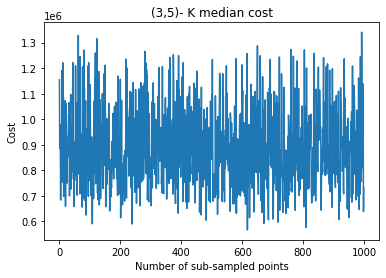

In [20]:

plt.plot(iter_no,  kmed) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Cost") 
title = "(" + str(p)+ "," + str(q) +")" + "- K median cost";
plt.title(title)
plt.show() 

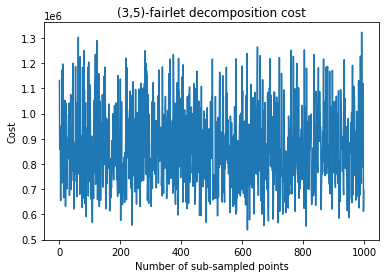

In [21]:

plt.plot(iter_no, fcost) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Cost") 
title = "(" + str(p)+ "," + str(q) +")" + "-fairlet decomposition cost";
plt.title(title)
plt.show() 

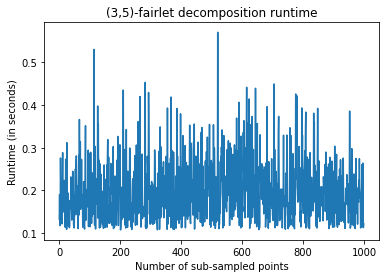

In [22]:

plt.plot(iter_no, fTime) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Runtime (in seconds)") 
title = "(" + str(p)+ "," + str(q) +")" + "-fairlet decomposition runtime";
plt.title(title)
plt.show() 

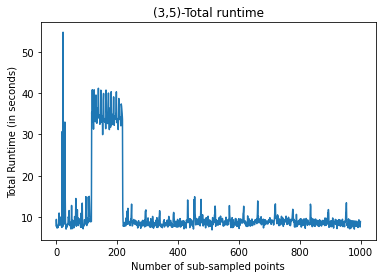

In [23]:

plt.plot(iter_no, tTime) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Total Runtime (in seconds)") 
title = "(" + str(p)+ "," + str(q) +")" + "-Total runtime";
plt.title(title)
plt.show() 

In [24]:

print("Kmedian cost\n")
print(kmed)

print("Fairlet Decomp cost\n")
print(fcost)

print("Fairlet Runtime\n")
print(fTime)

print("TOtal runtime\n")
print(tTime)

Kmedian cost

[1155149.22671704  885835.24936769  942748.88991022  915966.81870047
  683747.39562348  938844.34944525  980014.12823649  813742.17431334
  753119.18531055 1191878.76978359  888046.282057   1221274.38128726
  811771.00436331 1086329.38070471  697984.14278426  951360.71976792
  838649.70735423  869122.40694329  802518.17185858 1072449.82421627
  659312.28632113 1063225.97194055  859492.36914829  935526.19002638
  749230.71334029  798788.02963552  847644.47663357  901396.74790084
  852749.53493792  957635.39403019 1017874.05376965 1005657.96070064
 1065316.86524605  700147.15030688  836265.50023468  827538.21202396
 1007190.43497203 1097143.8144698   726768.77009701  977891.17689396
  860127.82275377  794519.90789523  812093.07899556  986069.84018802
 1221781.96032072  884170.13657265  766717.40940154  914253.13926882
  658534.32604065  793236.45483598  760049.46610617  865053.83293939
  806889.725247   1209427.45806849  780578.36242461  815522.35975514
 1063865.3538701  10

In [27]:
print("Minimum K-Median cost  "+str(min(kmed)))
print("Minimum Fairlet cost  "+str(min(fcost)))
print("Minimum Fairlet RUntime  "+str(min(fTime)))
print("Minimum TOtal RUntime  "+str(min(tTime)))

Minimum K-Median cost  566919.5090655257
Minimum Fairlet cost  538077.4051517278
Minimum Fairlet RUntime  0.10732030868530273
Minimum TOtal RUntime  6.866073846817017
